In [2]:
import os
import torch
import torchvision
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt

# PennFudan Dataset을 다운로드하고 압축을 푸는 코드
if not os.path.exists('PennFudanPed'):
    !wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
    !unzip PennFudanPed.zip

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        mask = torch.as_tensor(np.array(mask), dtype=torch.uint8)
        obj_ids = torch.unique(mask)[1:]  # 0은 배경이므로 제외

        masks = mask == obj_ids[:, None, None]
        boxes = []
        for i in range(len(obj_ids)):
            pos = torch.where(masks[i])
            xmin = torch.min(pos[1])
            xmax = torch.max(pos[1])
            ymin = torch.min(pos[0])
            ymax = torch.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(obj_ids),), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        target = {"boxes": boxes, "labels": labels, "masks": masks}

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

# 데이터셋 불러오기
dataset = PennFudanDataset('PennFudanPed')


In [5]:
import torchvision.models.detection
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

# PennFudan Dataset은 사람만 존재하므로 클래스는 2개 (사람, 배경)
model = get_model(num_classes=2)


c:\Users\Desktop\anaconda3\envs\st\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Desktop\anaconda3\envs\st\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

# 데이터셋 나누기 (80% 학습, 20% 테스트)
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 데이터 로더
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# 모델 학습
num_epochs = 10
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

loss_list = []
for epoch in range(num_epochs):
    model.train()
    for imgs, targets in tqdm(train_loader):
        imgs = list(F.to_tensor(img).to(device) for img in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch: {epoch}, Loss: {losses.item()}")
    loss_list.append(losses.item())


100%|██████████| 34/34 [00:35<00:00,  1.03s/it]


Epoch: 0, Loss: 0.06426498293876648


100%|██████████| 34/34 [00:39<00:00,  1.17s/it]


Epoch: 1, Loss: 0.030735138803720474


100%|██████████| 34/34 [00:47<00:00,  1.39s/it]


Epoch: 2, Loss: 0.026194583624601364


100%|██████████| 34/34 [00:45<00:00,  1.33s/it]


Epoch: 3, Loss: 0.046978674829006195


100%|██████████| 34/34 [00:38<00:00,  1.14s/it]


Epoch: 4, Loss: 0.03992209583520889


100%|██████████| 34/34 [00:41<00:00,  1.21s/it]


Epoch: 5, Loss: 0.028023971244692802


100%|██████████| 34/34 [00:47<00:00,  1.40s/it]


Epoch: 6, Loss: 0.04741588234901428


100%|██████████| 34/34 [00:35<00:00,  1.04s/it]


Epoch: 7, Loss: 0.03342225030064583


100%|██████████| 34/34 [00:39<00:00,  1.15s/it]


Epoch: 8, Loss: 0.017906010150909424


100%|██████████| 34/34 [00:40<00:00,  1.19s/it]

Epoch: 9, Loss: 0.07695546001195908


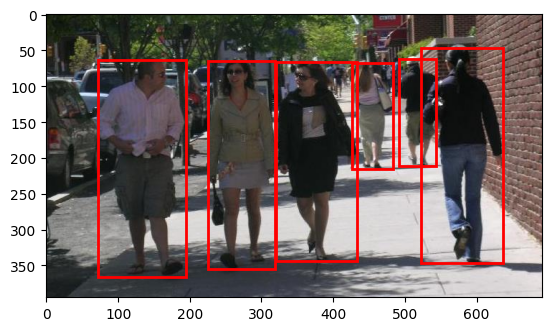

In [21]:
def visualize_prediction(model, dataset, device):
    model.eval()
    img, _ = dataset[0]
    img = F.to_tensor(img).to(device)
    with torch.no_grad():
        prediction = model([img])
    
    img = img.mul(255).permute(1, 2, 0).byte().cpu().numpy()
    plt.imshow(img)
    
    for box in prediction[0]['boxes'].cpu().numpy():
        xmin, ymin, xmax, ymax = box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, color='red', linewidth=2))
    
    plt.show()

# 테스트 데이터에 대한 예측 및 시각화
visualize_prediction(model, test_dataset, device)
